In [73]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ufc-fighters-statistics/ufc-fighters-statistics.csv


In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# set consistent, attractive styling
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")
plt.rcParams.update({
    'figure.figsize': (12, 6),
    'font.size': 10,
    'axes.titlesize': 12,
    'axes.labelsize': 10,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'legend.fontsize': 9,
    'figure.titlesize': 14
})

print("Libraries imported successfully!")

Libraries imported successfully!


In [75]:
df = pd.read_csv("/kaggle/input/ufc-fighters-statistics/ufc-fighters-statistics.csv")
print("Loaded:", df.shape)

Loaded: (4111, 18)


In [76]:
duplicate_count = df.duplicated().sum()
if duplicate_count:
    df = df.drop_duplicates()
    print(f"Dropped {duplicate_count} duplicate rows. New shape: {df.shape}")

df.info()
#There are no duplicates as print statement not printed

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4111 entries, 0 to 4110
Data columns (total 18 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   name                                          4111 non-null   object 
 1   nickname                                      2257 non-null   object 
 2   wins                                          4111 non-null   int64  
 3   losses                                        4111 non-null   int64  
 4   draws                                         4111 non-null   int64  
 5   height_cm                                     3813 non-null   float64
 6   weight_in_kg                                  4024 non-null   float64
 7   reach_in_cm                                   2184 non-null   float64
 8   stance                                        3288 non-null   object 
 9   date_of_birth                                 2976 non-null   o

In [77]:
def get_column_types(dataframe):
    return {
        'object_cols': dataframe.select_dtypes(include='object').columns,
        'numerical_cols': dataframe.select_dtypes(include=['number']).columns
    }

In [78]:
def plot_boxplots_for_outliers(dataframe, cols, title_suffix=""):
    n_rows, n_cols = create_subplot_grid(len(cols), 4)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 3))
    axes = axes.flatten()

    colors = sns.color_palette("coolwarm", len(cols))

    for i, col in enumerate(cols):
        ax = axes[i]

        # Create styled boxplot
        bp = ax.boxplot(dataframe[col].dropna(), patch_artist=True,
                       boxprops=dict(facecolor=colors[i], alpha=0.7),
                       medianprops=dict(color='black', linewidth=2),
                       flierprops=dict(marker='o', markerfacecolor='red', alpha=0.6, markersize=4))

        # Calculate outlier statistics
        Q1 = dataframe[col].quantile(0.25)
        Q3 = dataframe[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers_count = ((dataframe[col] < lower_bound) | (dataframe[col] > upper_bound)).sum()

        # Add outlier count annotation
        ax.text(0.02, 0.98, f'Outliers: {outliers_count}',
                transform=ax.transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7),
                fontsize=9)

        ax.set_title(f'{col}{title_suffix}', fontsize=11, pad=10)
        ax.set_ylabel('Value', fontsize=10)
        ax.grid(True, alpha=0.3)

    # Remove extra subplots
    for j in range(len(cols), len(axes)):
        fig.delaxes(axes[j])

    return fig, axes

In [79]:
def create_subplot_grid(n_items, max_cols=4):
    n_cols = min(max_cols, n_items)
    n_rows = (n_items + n_cols - 1) // n_cols
    return n_rows, n_cols

def plot_categorical_distributions(dataframe, cols, title_suffix="", figsize_multiplier=3):
    n_rows, n_cols = create_subplot_grid(len(cols), 4)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * figsize_multiplier))
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    axes = axes.flatten()

    colors = sns.color_palette("Set2", len(cols))

    for i, col in enumerate(cols):
        counts = dataframe[col].value_counts(dropna=False)
        counts.plot(kind='bar', ax=axes[i], color=colors[i], alpha=0.8)
        axes[i].set_title(f'{col.title()}{title_suffix}', fontsize=12, pad=10)
        axes[i].set_xlabel('')
        axes[i].set_ylabel('Count', fontsize=10)
        axes[i].tick_params(axis='x', rotation=45, labelsize=9)

        # Add count labels on bars
        for j, v in enumerate(counts.values):
            axes[i].text(j, v + max(counts.values) * 0.01, str(v),
                        ha='center', va='bottom', fontsize=8)

    # Remove extra subplots
    for j in range(len(cols), len(axes)):
        fig.delaxes(axes[j])

    return fig, axes

def plot_numerical_distributions(dataframe, cols, title_suffix="", show_missing=True):
    n_rows, n_cols = create_subplot_grid(len(cols), 4)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 3))
    axes = axes.flatten()

    colors = sns.color_palette("plasma", len(cols))

    for i, col in enumerate(cols):
        ax = axes[i]

        # Create histogram
        dataframe[col].hist(bins=20, ax=ax, alpha=0.7, color=colors[i],
                           edgecolor='black', linewidth=0.5)

        # Add statistics
        col_mean = dataframe[col].mean()
        col_median = dataframe[col].median()
        col_missing = dataframe[col].isnull().sum()

        ax.axvline(col_mean, color='red', linestyle='--', alpha=0.8,
                  label=f'Mean: {col_mean:.1f}')
        ax.axvline(col_median, color='blue', linestyle='--', alpha=0.8,
                  label=f'Median: {col_median:.1f}')

        ax.set_title(f'{col}{title_suffix}', fontsize=11, pad=10)
        ax.set_xlabel('')
        ax.set_ylabel('Frequency', fontsize=10)
        ax.legend(fontsize=8, loc='upper right')

        # Add missing count annotation if requested
        if show_missing and col_missing > 0:
            ax.text(0.02, 0.98, f'Missing: {col_missing}', transform=ax.transAxes,
                    verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='orange', alpha=0.7),
                    fontsize=8)
        elif not show_missing:
            ax.text(0.02, 0.98, f'Complete: {len(dataframe) - col_missing}/{len(dataframe)}',
                    transform=ax.transAxes, verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7),
                    fontsize=8)

    # Remove extra subplots
    for j in range(len(cols), len(axes)):
        fig.delaxes(axes[j])

    return fig, axes

In [80]:
def cap_outliers_iqr(dataframe, columns, multiplier=1.5):
    df_capped = dataframe.copy()
    outlier_stats = {}

    for col in columns:
        if col in df_capped.columns:
            Q1 = df_capped[col].quantile(0.25)
            Q3 = df_capped[col].quantile(0.75)
            IQR = Q3 - Q1

            lower_bound = Q1 - multiplier * IQR
            upper_bound = Q3 + multiplier * IQR

            outliers_before = ((df_capped[col] < lower_bound) | (df_capped[col] > upper_bound)).sum()

            df_capped[col] = df_capped[col].clip(lower_bound, upper_bound)

            outliers_after = ((df_capped[col] < lower_bound) | (df_capped[col] > upper_bound)).sum()

            outlier_stats[col] = {
                'outliers_before': int(outliers_before),
                'outliers_after': int(outliers_after),
                'lower_bound': float(lower_bound),
                'upper_bound': float(upper_bound),
                'Q1': float(Q1),
                'Q3': float(Q3),
                'IQR': float(IQR)
            }

    return df_capped, outlier_stats

In [81]:
# Define column types once - this will be updated as data changes
column_info = get_column_types(df)
print(f"Dataset loaded with {len(column_info['object_cols'])} categorical and {len(column_info['numerical_cols'])} numerical columns")

Dataset loaded with 4 categorical and 14 numerical columns


In [82]:
df.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,name,nickname,wins,losses,draws,height_cm,weight_in_kg,reach_in_cm,stance,date_of_birth,significant_strikes_landed_per_minute,significant_striking_accuracy,significant_strikes_absorbed_per_minute,significant_strike_defence,average_takedowns_landed_per_15_minutes,takedown_accuracy,takedown_defense,average_submissions_attempted_per_15_minutes
0,Robert Drysdale,NaN,7,0,0,190.50,92.99,NaN,Orthodox,1981-10-05,0.00,0.0,0.00,0.0,7.32,100.0,0.0,21.9
1,Daniel McWilliams,The Animal,15,37,0,185.42,83.91,NaN,NaN,NaN,3.36,77.0,0.00,0.0,0.00,0.0,100.0,21.6
2,Dan Molina,NaN,13,9,0,177.80,97.98,NaN,NaN,NaN,0.00,0.0,5.58,60.0,0.00,0.0,0.0,20.9
3,Paul Ruiz,NaN,7,4,0,167.64,61.23,NaN,NaN,NaN,1.40,33.0,1.40,75.0,0.00,0.0,100.0,20.9
4,Collin Huckbody,All In,8,2,0,190.50,83.91,193.04,Orthodox,1994-09-29,2.05,60.0,2.73,42.0,10.23,100.0,0.0,20.4


In [83]:
df.describe()

,wins,losses,draws,height_cm,weight_in_kg,reach_in_cm,significant_strikes_landed_per_minute,significant_striking_accuracy,significant_strikes_absorbed_per_minute,significant_strike_defence,average_takedowns_landed_per_15_minutes,takedown_accuracy,takedown_defense,average_submissions_attempted_per_15_minutes
count,4111.000000,4111.000000,4111.000000,3813.000000,4024.000000,2184.000000,4111.000000,4111.000000,4111.000000,4111.000000,4111.000000,4111.000000,4111.000000,4111.000000
mean,12.366821,5.726344,0.264413,178.234325,77.395825,181.808874,2.437516,35.542447,3.145206,42.643639,1.250586,26.299927,38.958891,0.610095
std,9.374667,5.103768,0.822373,8.888050,17.982242,10.680804,1.990903,20.398502,2.848502,22.322427,1.935716,28.700980,34.426458,1.505924
min,0.000000,0.000000,0.000000,152.400000,47.630000,147.320000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.000000,2.000000,0.000000,172.720000,65.770000,175.260000,0.830000,27.000000,1.550000,36.000000,0.000000,0.000000,0.000000,0.000000
50%,11.000000,5.000000,0.000000,177.800000,77.110000,182.880000,2.330000,40.000000,2.940000,50.000000,0.590000,22.000000,42.000000,0.000000
75%,17.000000,8.000000,0.000000,185.420000,83.910000,190.500000,3.600000,49.000000,4.230000,58.000000,1.940000,45.000000,66.000000,0.700000
max,253.000000,83.000000,11.000000,226.060000,349.270000,213.360000,17.650000,100.000000,52.500000,100.000000,32.140000,100.000000,100.000000,21.900000


Total missing values: 6124
Percentage missing: 8.28%


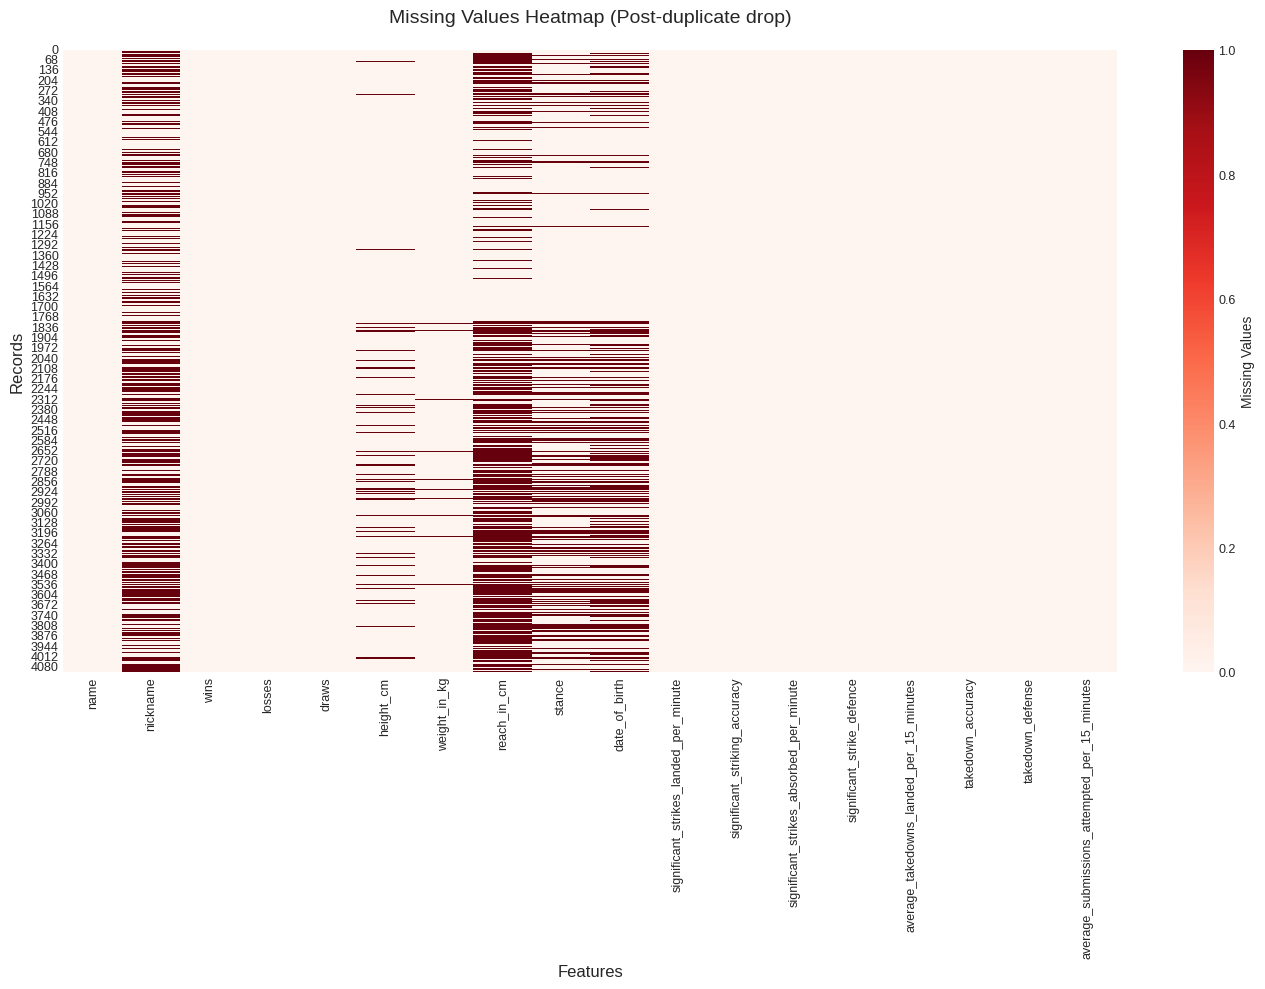

In [84]:
# calculate missing values statistics once
missing_stats = {
    'missing_values': df.isnull().sum(),
    'total_missing': df.isnull().sum().sum(),
    'total_cells': df.shape[0] * df.shape[1]
}

print(f"Total missing values: {missing_stats['total_missing']}")
print(f"Percentage missing: {(missing_stats['total_missing'] / missing_stats['total_cells']) * 100:.2f}%")

# clean, focused heatmap
fig, ax = plt.subplots(figsize=(14,10))
sns.heatmap(df.isnull(), cbar=True, cmap='Reds',
           cbar_kws={'label': 'Missing Values'}, ax=ax)
ax.set_title('Missing Values Heatmap (Post-duplicate drop)', fontsize=14, pad=20)
ax.set_xlabel('Features', fontsize=12)
ax.set_ylabel('Records', fontsize=12)
plt.tight_layout()
plt.show()

In [101]:
###################################
#df.drop(columns=['nickname'], inplace=True)

In [86]:
# analyze categorical columns (using predefined column_info)
print("Categorical column unique values:")
unique_vals = df['stance'].value_counts(dropna=False).index.tolist()
print(f"stance: {unique_vals}")

Categorical column unique values:
stance: ['Orthodox', nan, 'Southpaw', 'Switch', 'Open Stance', 'Sideways']


Outlier detection analysis using boxplots:


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


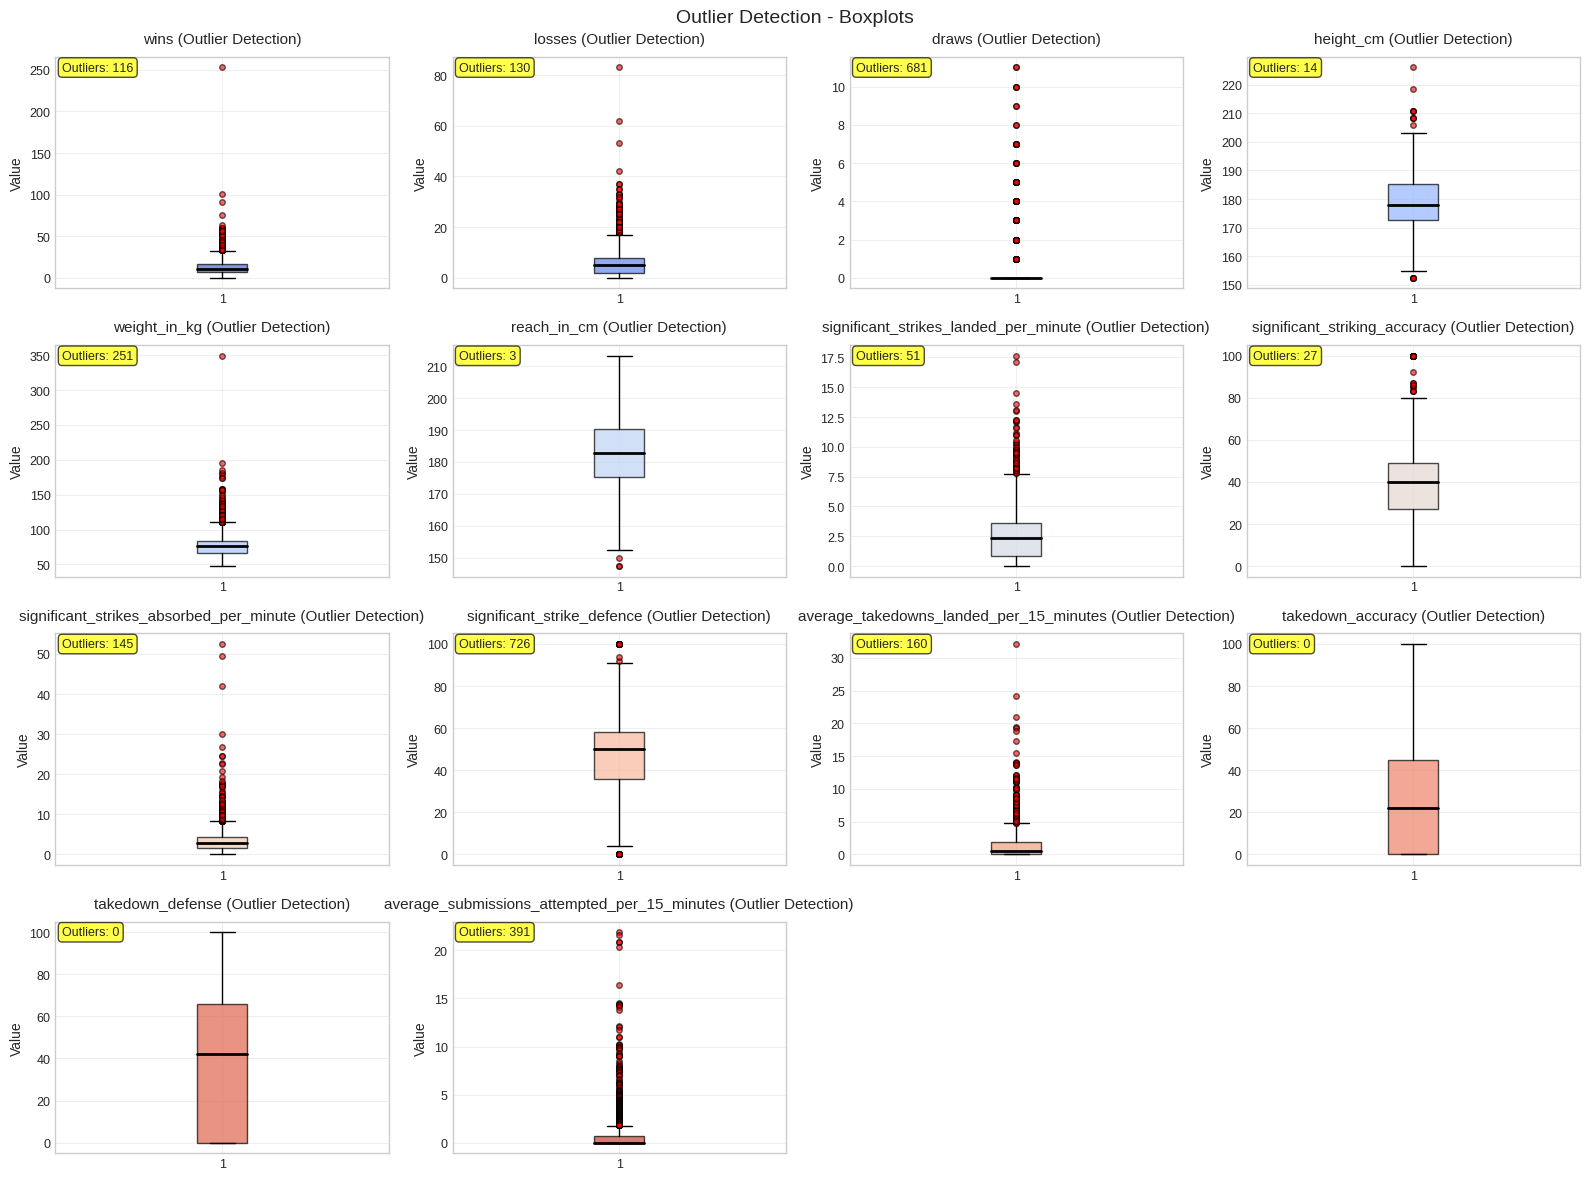

In [87]:
# display outlier detection using boxplots
print("Outlier detection analysis using boxplots:")
fig, axes = plot_boxplots_for_outliers(df, column_info['numerical_cols'],
                                      title_suffix=" (Outlier Detection)")
plt.suptitle('Outlier Detection - Boxplots', fontsize=14, y=0.98)
plt.tight_layout()
plt.show()

In [88]:
# store original data for comparison
df_before_capping = df.copy()

# apply IQR-based winsorization (clipping) to numeric features except target
print("Applying outlier capping using IQR clipping (multiplier=2.5)...")
num_cols = column_info['numerical_cols'].drop('G3', errors='ignore')
df_capped, outlier_statistics = cap_outliers_iqr(df, num_cols, multiplier=2.5)

# display outlier statistics
total_outliers_capped = 0
print("Outlier analysis results:")
for col, stats in outlier_statistics.items():
    if stats['outliers_before'] > 0:
        print(f"{col}: {stats['outliers_before']} -> {stats['outliers_after']} after capping")
        total_outliers_capped += stats['outliers_before']

print(f"Total outliers processed: {total_outliers_capped}")
print(f"Percentage of cells affected: {(total_outliers_capped / (len(df) * len(num_cols))) * 100:.2f}%")

# update the main dataframe
df = df_capped.copy()

Applying outlier capping using IQR clipping (multiplier=2.5)...
Outlier analysis results:
wins: 29 -> 0 after capping
losses: 40 -> 0 after capping
draws: 681 -> 0 after capping
height_cm: 2 -> 0 after capping
weight_in_kg: 32 -> 0 after capping
significant_strikes_landed_per_minute: 16 -> 0 after capping
significant_strikes_absorbed_per_minute: 57 -> 0 after capping
average_takedowns_landed_per_15_minutes: 75 -> 0 after capping
average_submissions_attempted_per_15_minutes: 223 -> 0 after capping
Total outliers processed: 1155
Percentage of cells affected: 2.01%


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressio

Outliers after capping:


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


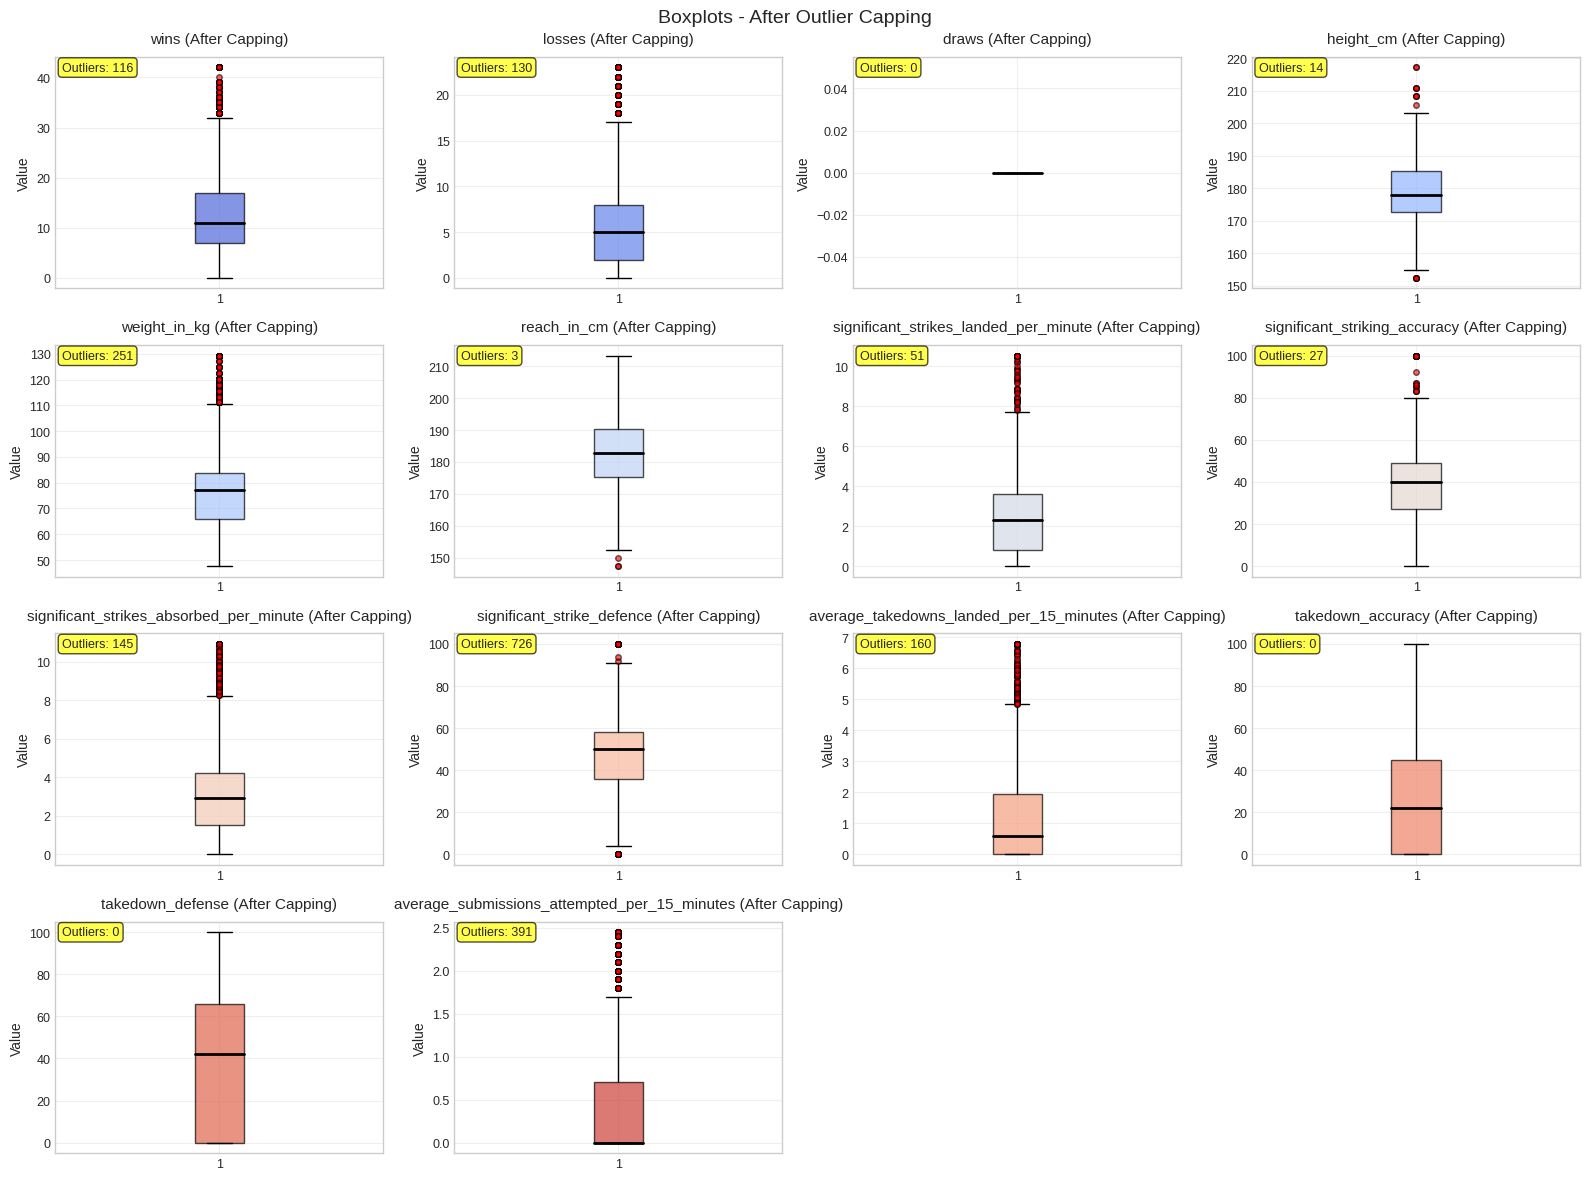

In [89]:
# visualize outliers after capping using boxplots
print("Outliers after capping:")
fig, axes = plot_boxplots_for_outliers(df, column_info['numerical_cols'],
                                      title_suffix=" (After Capping)")
plt.suptitle('Boxplots - After Outlier Capping', fontsize=14, y=0.98)
plt.tight_layout()
plt.show()

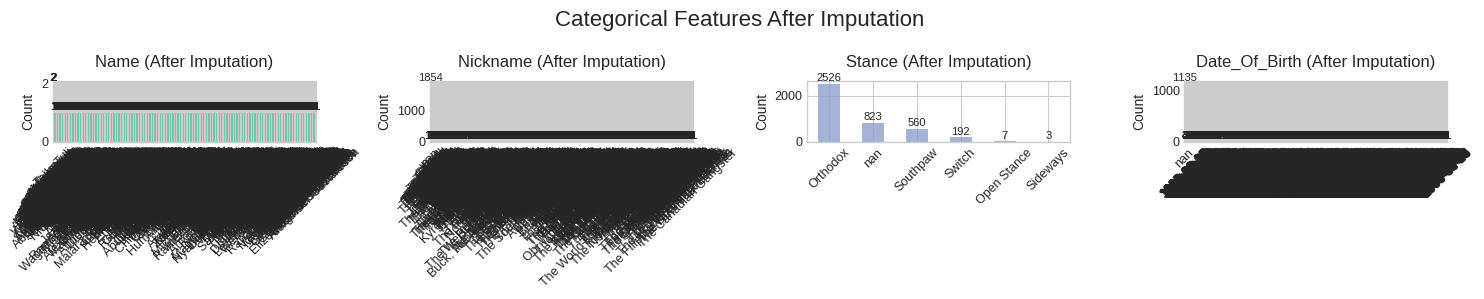

In [90]:
####### only for stance column
# visualize categorical distributions after imputation using reusable function
fig, axes = plot_categorical_distributions(df, column_info['object_cols'],
                                         title_suffix=" (After Imputation)", figsize_multiplier=3)
plt.suptitle('Categorical Features After Imputation', fontsize=16, y=0.98)
plt.tight_layout()
plt.show()

Distribution before Imputation:


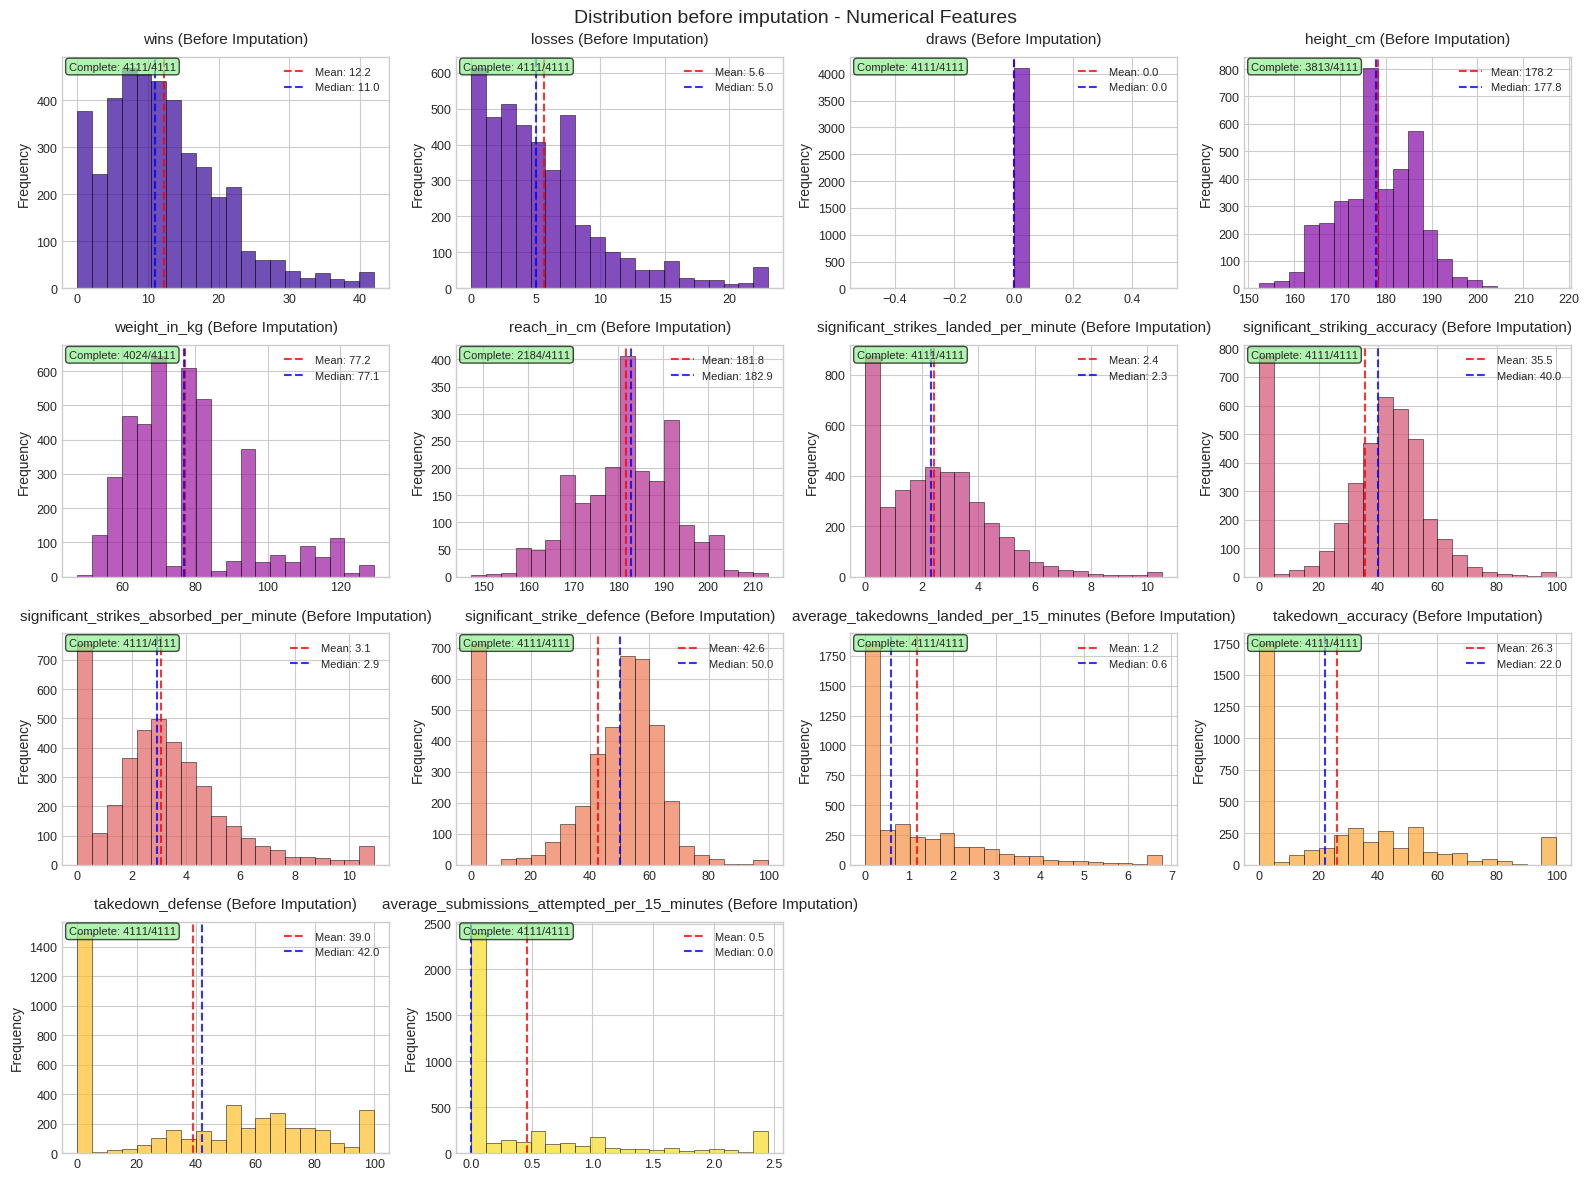

In [91]:
print("Distribution before Imputation:")

num_cols = column_info['numerical_cols'].drop('G3', errors='ignore')
fig, axes = plot_numerical_distributions(df, num_cols,
                                       title_suffix=" (Before Imputation)",
                                       show_missing=False)
plt.suptitle('Distribution before imputation - Numerical Features', fontsize=14, y=0.98)
plt.tight_layout()
plt.show()

In [92]:
print("Numerical imputation:")

from pandas.api.types import is_integer_dtype

imputation_summary = []
num_cols = column_info['numerical_cols'].drop('G3', errors='ignore')
orig_dtypes = df[num_cols].dtypes

for col in num_cols:
    missing_count = df[col].isnull().sum()
    if missing_count == 0:
        continue

    skew = df[col].skew() if not pd.isna(df[col].skew()) else 0
    if abs(skew) > 1:
        value = df[col].median()
        method = "median (due to skewness)"
    else:
        value = df[col].mean()
        method = "mean"

    df[col] = df[col].fillna(value)
    if is_integer_dtype(orig_dtypes[col]):
        df[col] = df[col].round().astype('Int64')

    if col in {"G1", "G2"}:
        df[col] = df[col].clip(0, 20)
    if col == "absences":
        df[col] = df[col].clip(lower=0)

    imputation_summary.append({
        'column': col,
        'missing_count': int(missing_count),
        'method': method,
        'value': float(value)
    })
    print(f"{col}: Imputed {missing_count} missing values with {method}")

if not imputation_summary:
    print("No missing values found in numerical columns")
else:
    total_imputed = sum(item['missing_count'] for item in imputation_summary)
    print(f"Total values imputed: {total_imputed}")

Numerical imputation:
height_cm: Imputed 298 missing values with mean
weight_in_kg: Imputed 87 missing values with mean
reach_in_cm: Imputed 1927 missing values with mean
Total values imputed: 2312


Distribution after imputation:


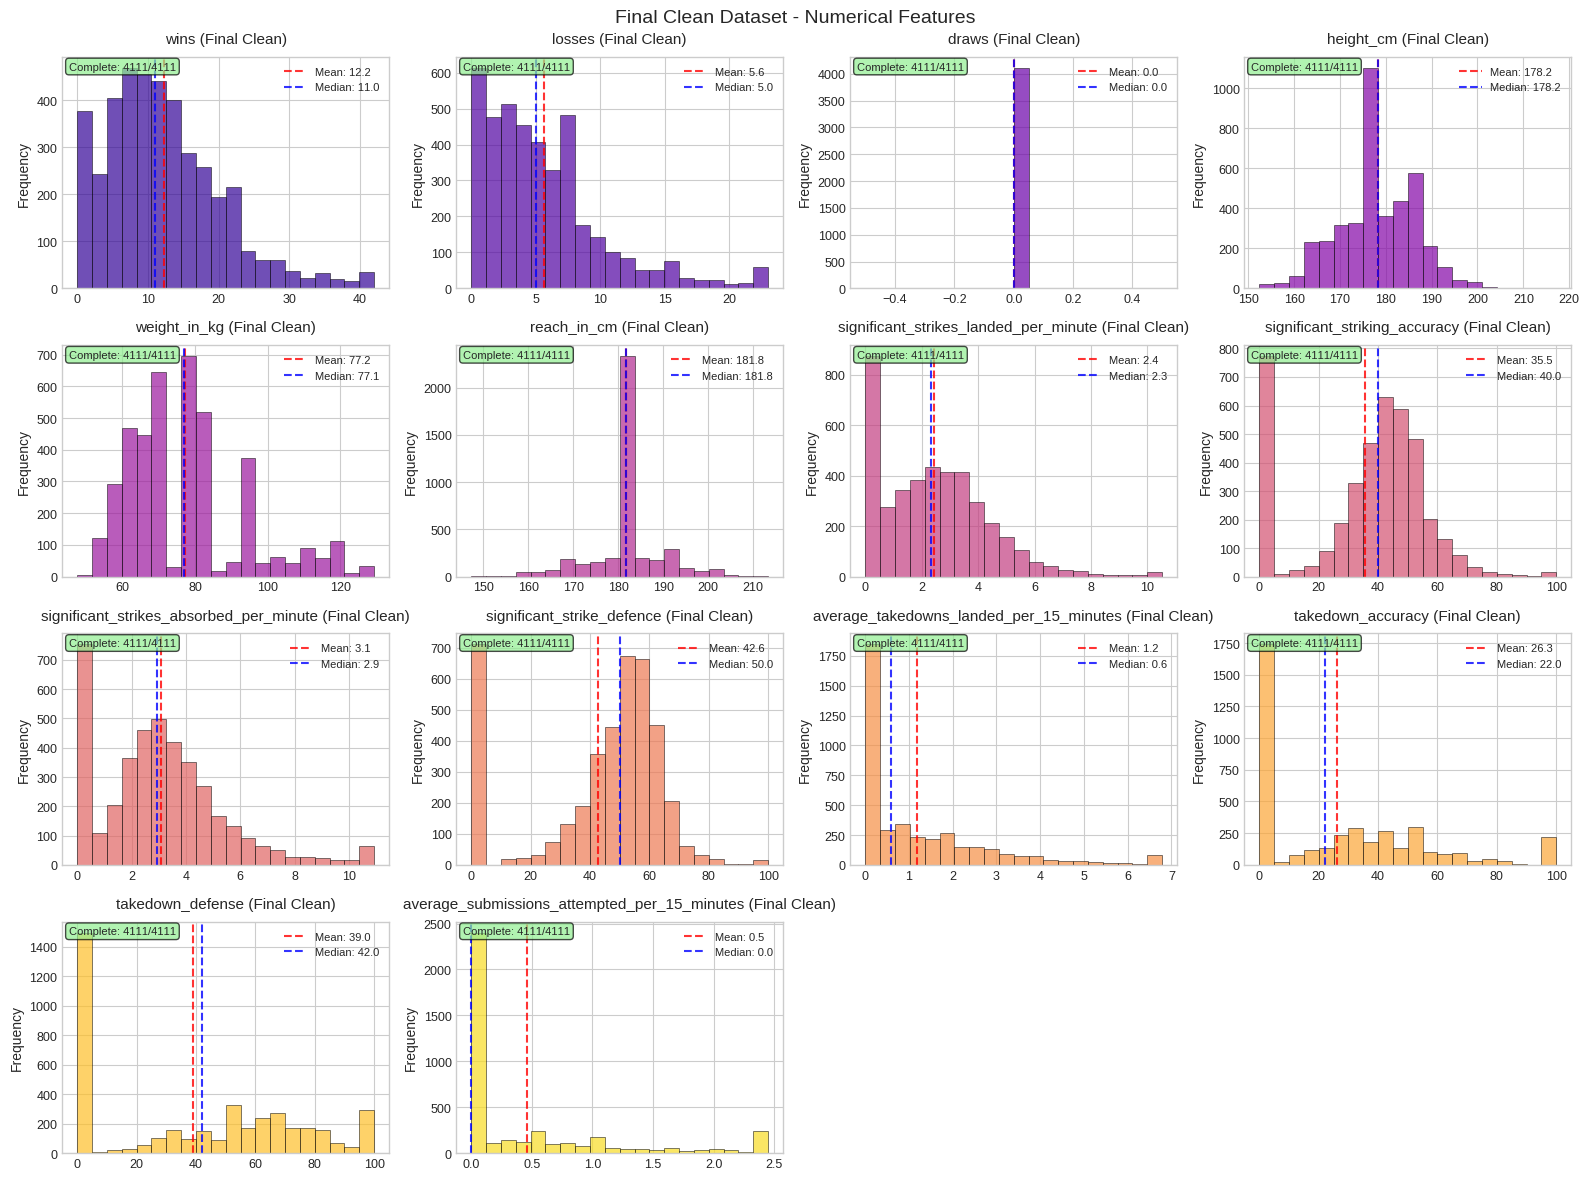

In [93]:
# final clean dataset visualization and summary
print("Distribution after imputation:")

num_cols = column_info['numerical_cols'].drop('G3', errors='ignore')
fig, axes = plot_numerical_distributions(df, num_cols,
                                       title_suffix=" (Final Clean)",
                                       show_missing=False)
plt.suptitle('Final Clean Dataset - Numerical Features', fontsize=14, y=0.98)
plt.tight_layout()
plt.show()

In [94]:
print(f"\nFinal dataset summary:")
print(f"Shape: {df.shape[0]} rows x {df.shape[1]} columns")
print(f"Missing values: {df.isnull().sum().sum()}")
print(f"Duplicate rows: {df.duplicated().sum()}")
print(f"Categorical columns: {len(column_info['object_cols'])}")
print(f"Numerical columns: {len(column_info['numerical_cols'])}")

# save cleaned dataset
df.to_csv("student-mat-cleaned.csv", index=False)
print("Saved cleaned dataset to student-mat-cleaned.csv")


Final dataset summary:
Shape: 4111 rows x 18 columns
Missing values: 3812
Duplicate rows: 0
Categorical columns: 4
Numerical columns: 14
Saved cleaned dataset to student-mat-cleaned.csv


In [113]:
df["total_fights"] = df["wins"] + df["losses"] + df["draws"]
df["win_rate"] = (df["wins"] / df["total_fights"]) * 100

In [114]:
phys_cols = ["height_cm", "weight_in_kg", "reach_in_cm"]
perf_cols = ["win_rate",
             "significant_strikes_landed_per_minute",
             "significant_striking_accuracy",
             "significant_strike_defence",
             "takedown_accuracy",
             "takedown_defense"]

In [116]:
# Correlation analysis
corr_matrix = df[phys_cols + perf_cols].corr().round(2)
print("Correlation matrix (physical vs performance):")
print(corr_matrix.loc[phys_cols, perf_cols])

Correlation matrix (physical vs performance):
              win_rate  significant_strikes_landed_per_minute  \
height_cm        -0.05                                  -0.03   
weight_in_kg     -0.17                                  -0.15   
reach_in_cm       0.02                                   0.01   

              significant_striking_accuracy  significant_strike_defence  \
height_cm                              0.01                       -0.12   
weight_in_kg                          -0.07                       -0.20   
reach_in_cm                            0.05                       -0.05   

              takedown_accuracy  takedown_defense  
height_cm                 -0.02             -0.05  
weight_in_kg              -0.06             -0.13  
reach_in_cm                0.01              0.01  


In [119]:
# --- Scatter Plots: Physical vs Win Rate ---
def scatter_plot(x, y, xlabel, ylabel, title):
    data = df[[x, y]].dropna()
    plt.figure(figsize=(6,4))
    plt.scatter(data[x], data[y], s=10, alpha=0.5)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

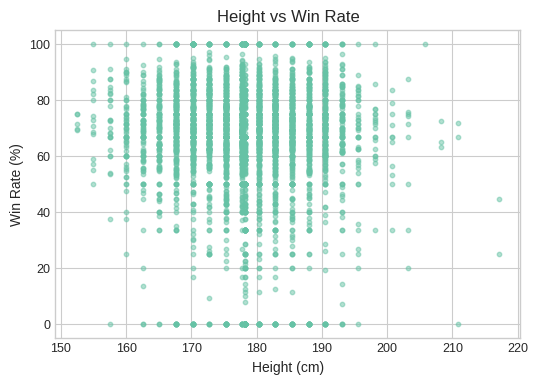

In [120]:
# Height vs Win Rate
scatter_plot("height_cm", "win_rate",
             "Height (cm)", "Win Rate (%)",
             "Height vs Win Rate")


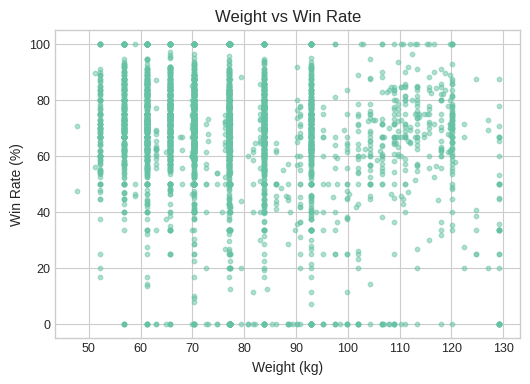

In [121]:
# Weight vs Win Rate
scatter_plot("weight_in_kg", "win_rate",
             "Weight (kg)", "Win Rate (%)",
             "Weight vs Win Rate")


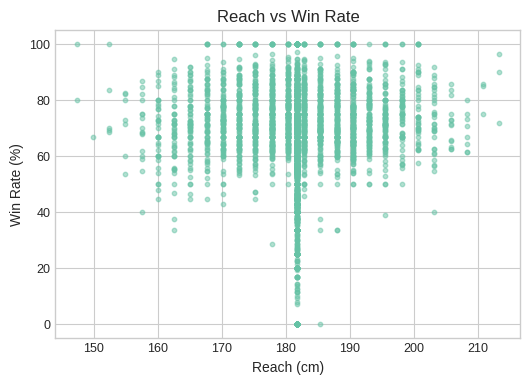

In [122]:
# Reach vs Win Rate
scatter_plot("reach_in_cm", "win_rate",
             "Reach (cm)", "Win Rate (%)",
             "Reach vs Win Rate")


In [123]:
# Group by stance and calculate average win_rate
stance_winrate = df.groupby("stance")["win_rate"].mean().sort_values(ascending=False)
print("Average Win Rate by Stance:\n", stance_winrate)

Average Win Rate by Stance:
 stance
Switch         74.249244
Southpaw       69.145914
Orthodox       68.368668
Open Stance    58.122632
Sideways       38.888889
Name: win_rate, dtype: float64


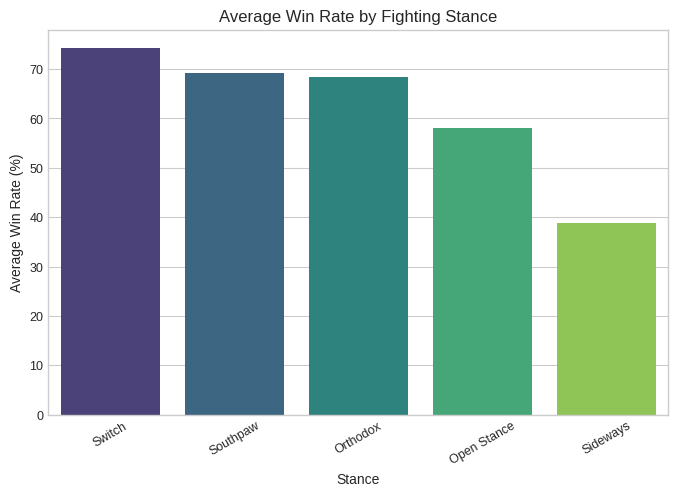

In [124]:
# Plot
plt.figure(figsize=(8,5))
sns.barplot(x=stance_winrate.index, y=stance_winrate.values, palette="viridis")
plt.title("Average Win Rate by Fighting Stance")
plt.xlabel("Stance")
plt.ylabel("Average Win Rate (%)")
plt.xticks(rotation=30)
plt.show()

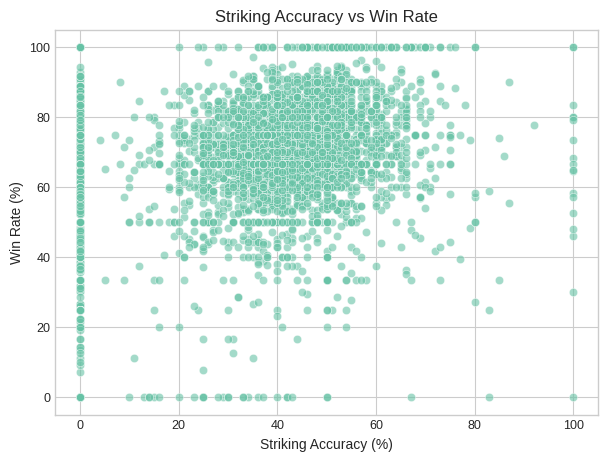

In [125]:
# Scatter plot of striking accuracy vs win rate
plt.figure(figsize=(7,5))
sns.scatterplot(x=df["significant_striking_accuracy"], y=df["win_rate"], alpha=0.6)
plt.title("Striking Accuracy vs Win Rate")
plt.xlabel("Striking Accuracy (%)")
plt.ylabel("Win Rate (%)")
plt.show()

Correlation between striking accuracy and win rate: 0.35


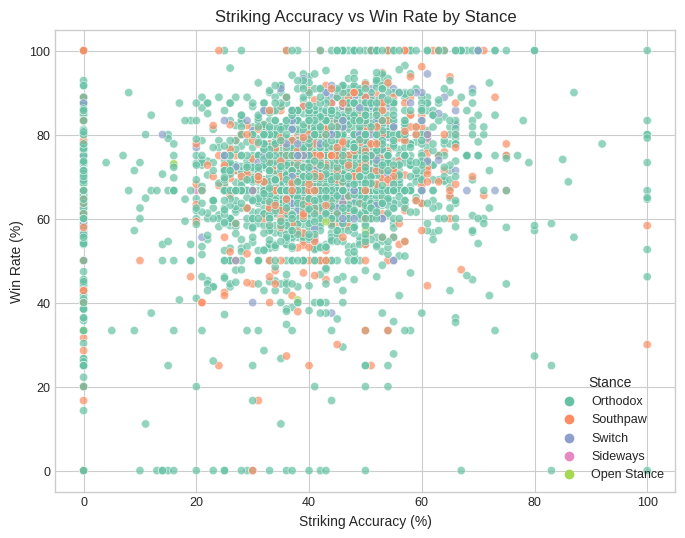

In [126]:
# Correlation
corr = df["significant_striking_accuracy"].corr(df["win_rate"])
print("Correlation between striking accuracy and win rate:", round(corr, 2))

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df, 
    x="significant_striking_accuracy", 
    y="win_rate", 
    hue="stance", 
    alpha=0.7
)
plt.title("Striking Accuracy vs Win Rate by Stance")
plt.xlabel("Striking Accuracy (%)")
plt.ylabel("Win Rate (%)")
plt.legend(title="Stance")
plt.show()
